# Modeling RandomForest untuk InsectSound
Gunakan fitur hasil preprocessing (.csv) lalu latih & evaluasi RandomForest.

In [3]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
import joblib
from scipy.fft import fft, fftfreq
from scipy.io import arff
import numpy as np
from scipy.stats import randint
import librosa

## Data Preprocessing

In [4]:
data_train, meta_train = arff.loadarff('./InsectSound/InsectSound_TRAIN.arff')

data_test, meta_test = arff.loadarff('./InsectSound/InsectSound_TEST.arff')

In [5]:
df_train_time_domain = pd.DataFrame(data_train)
df_test_time_domain = pd.DataFrame(data_test)

df_train_time_domain['target'] = df_train_time_domain['target'].str.decode('utf-8')

df_test_time_domain['target'] = df_test_time_domain['target'].str.decode('utf-8')

In [6]:
df_train_time_domain

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att592,att593,att594,att595,att596,att597,att598,att599,att600,target
0,0.000153,-6.578439e-05,0.000038,-0.000029,0.000020,-0.000006,0.000004,0.000002,0.000003,-0.000003,...,-0.000003,0.000010,-0.000006,-0.000006,-0.000010,0.000011,-4.337056e-07,0.000013,-0.000024,Aedes_female
1,-0.000029,6.673935e-07,0.000035,-0.000119,-0.000141,-0.000131,-0.000251,-0.000253,-0.000261,-0.000309,...,0.001548,0.001509,0.001564,0.001499,0.001487,0.001473,1.498447e-03,0.001388,0.001597,Aedes_female
2,-0.019499,4.194278e-02,0.192660,0.232282,0.132188,0.013040,-0.035715,-0.066381,-0.070153,-0.050134,...,0.087443,0.234516,0.242373,0.130852,0.042257,-0.005834,-7.398573e-02,-0.047510,-0.037126,Aedes_female
3,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,Aedes_female
4,0.000023,-7.772223e-05,0.000111,-0.000096,0.000043,0.000023,-0.000083,0.000119,-0.000104,0.000058,...,-0.000201,-0.000108,-0.000037,0.000045,0.000112,0.000165,2.464727e-04,0.000267,0.000361,Aedes_female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,-0.038172,-6.510722e-02,-0.050728,-0.057015,-0.059738,-0.062525,-0.041550,-0.029602,-0.071081,-0.085259,...,0.015370,0.011291,0.007858,0.000036,-0.009820,-0.016796,-2.788711e-02,-0.035114,-0.043915,Tarsalis_male
24996,-0.004521,-5.507769e-03,-0.003324,-0.002715,-0.001349,-0.000586,0.000324,0.000365,0.000511,0.000505,...,-0.002677,-0.002820,-0.002841,-0.002871,-0.002874,-0.002720,-2.747607e-03,-0.002502,-0.002782,Tarsalis_male
24997,0.000001,1.723497e-05,0.000005,-0.000009,-0.000001,-0.000002,-0.000010,0.000010,-0.000008,0.000007,...,-0.007817,-0.007665,-0.007593,-0.007307,-0.007141,-0.006762,-6.597169e-03,-0.005984,-0.006218,Tarsalis_male
24998,-0.000047,-5.119860e-05,-0.000045,-0.000071,-0.000065,-0.000030,-0.000031,-0.000056,-0.000067,-0.000051,...,-0.130079,-0.118307,-0.106510,-0.110060,-0.106163,-0.085816,-6.483196e-02,-0.050146,-0.114638,Tarsalis_male


In [7]:
from scipy.fft import rfft, rfftfreq

def extract_features_v2(signal: np.ndarray) -> dict:
    fft_values = np.abs(rfft(signal))
    fft_freqs = rfftfreq(len(signal), 1 / 6000)
    mfcc = librosa.feature.mfcc(y=signal, sr=6000, n_mfcc=13)

    return fft_values.tolist() + mfcc.flatten().tolist()


def build_feature_df_v2(df_in: pd.DataFrame) -> pd.DataFrame: 
    rows = [] 
    for row in df_in.itertuples(index=False): 
        signal = np.asarray(row, dtype=float) 
        feats = extract_features_v2(signal) 
        rows.append(feats)
        
    return pd.DataFrame(rows)


In [8]:
X_train = df_train_time_domain.drop('target', axis=1)
y_train = df_train_time_domain['target']
X_train = build_feature_df_v2(X_train)

X_test = df_test_time_domain.drop('target', axis=1)
y_test = df_train_time_domain['target']
X_test = build_feature_df_v2(X_test)

C:\Users\grubg\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=600
  warnings.warn(
C:\Users\grubg\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=600
  warnings.warn(


In [9]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,317,318,319,320,321,322,323,324,325,326
0,0.005107,0.003539,0.004149,0.011252,0.003870,0.003155,0.042232,0.154303,0.345499,0.599401,...,-4.095212,-4.197743,62.648136,63.888668,-63.474093,-64.317209,-3.816917,-6.269735,19.317396,20.483596
1,0.276832,0.890035,1.616741,2.549686,1.589538,0.527910,0.680788,0.465630,0.519724,0.369701,...,-28.675469,-28.785781,-6.357625,-8.372556,70.978469,71.827293,111.085970,109.507699,-2.204282,-3.515510
2,0.534062,1.852436,2.883891,2.586658,0.420808,1.707434,1.508141,0.309464,0.939695,0.622383,...,-20.226410,-18.691676,-0.325396,-3.622865,9.973030,14.435670,62.655595,59.141480,35.095852,38.291816
3,0.401689,1.139451,5.240613,4.823131,1.369612,3.438861,3.060122,1.713568,0.930940,0.727151,...,-13.368533,-18.459821,-9.010316,-8.754565,2.842191,1.929718,133.361574,139.556724,84.108706,85.742414
4,0.053369,1.676477,4.024979,3.542231,0.911268,1.725657,2.026754,1.463920,0.787932,0.433794,...,2.970260,2.488006,-1.869456,-2.324577,52.999338,53.163958,76.691293,75.682660,-7.602454,-8.448108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,2.373291,3.465740,4.685130,4.794371,4.013827,3.043128,2.308609,1.751479,1.221384,0.754629,...,58.792026,54.990256,-30.014661,-34.719269,-23.941354,-24.767210,24.524109,31.091952,-27.659927,-26.416182
24996,0.110527,4.393731,6.324274,11.898503,5.066463,2.787707,7.776737,3.446319,0.985013,2.038244,...,47.063761,52.634117,70.114603,72.722794,-9.059812,-9.802853,-27.146194,-27.419409,10.995747,11.449263
24997,0.175345,0.318406,0.576880,1.069494,1.796735,2.453382,2.704819,2.427631,1.809450,1.220844,...,116.719365,110.201192,37.700392,33.032443,-33.700549,-34.871602,4.067087,4.590823,-10.879973,-8.847670
24998,1.169293,1.949760,2.118444,2.599885,3.938090,6.307116,9.738017,11.861605,11.155698,8.172643,...,20.472523,22.400071,-22.952498,-22.139587,-1.884693,-2.953150,14.719894,13.974854,-30.441784,-26.188216


## Modeling Random Forest

### Global Classifier

In [10]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
y_pred_search = random_forest.predict(X_test)
print("Accuracy (best RF):", accuracy_score(y_test, y_pred_search))
print(classification_report(y_test, y_pred_search))

Accuracy (best RF): 0.73336
                 precision    recall  f1-score   support

   Aedes_female       0.68      0.65      0.67      2500
     Aedes_male       0.86      0.92      0.89      2500
    Fruit_flies       0.78      0.79      0.78      2500
    House_flies       0.76      0.79      0.78      2500
   Quinx_female       0.65      0.63      0.64      2500
     Quinx_male       0.63      0.62      0.63      2500
  Stigma_female       0.65      0.70      0.68      2500
    Stigma_male       0.80      0.86      0.83      2500
Tarsalis_female       0.87      0.78      0.82      2500
  Tarsalis_male       0.64      0.58      0.61      2500

       accuracy                           0.73     25000
      macro avg       0.73      0.73      0.73     25000
   weighted avg       0.73      0.73      0.73     25000



In [12]:
import joblib

joblib.dump(random_forest, 'random_forest.pkl')

['random_forest.pkl']

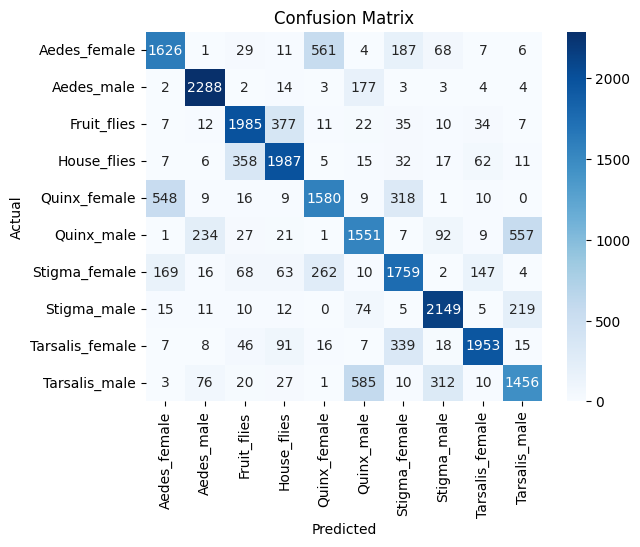

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred_search), annot=True, fmt='d', cmap='Blues', xticklabels=random_forest.classes_, yticklabels=random_forest.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Quinx vs Aedes Classifier

In [14]:
quinx_vs_aedes = ['Aedes_female', 'Quinx_female']

qva_train = X_train.copy()
qva_train['target'] = y_train
qva_train = qva_train[qva_train['target'].isin(quinx_vs_aedes)]
X_qva_train = qva_train.drop('target', axis=1)
y_qva_train = qva_train['target']

qva_test = X_test.copy()
qva_test['target'] = y_test
qva_test = qva_test[qva_test['target'].isin(quinx_vs_aedes)]
X_qva_test = qva_test.drop('target', axis=1)
y_qva_test = qva_test['target']

In [15]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

svc = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1.0, probability=True, 
                    class_weight='balanced', random_state=42))
    ])

svc.fit(X_qva_train, y_qva_train)

,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [16]:
joblib.dump(svc, 'svc.pkl')

['svc.pkl']

In [17]:
y_qva_pred = svc.predict(X_qva_test)
report = classification_report(y_qva_test, y_qva_pred)
print(report)

              precision    recall  f1-score   support

Aedes_female       0.80      0.72      0.76      2500
Quinx_female       0.74      0.82      0.78      2500

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



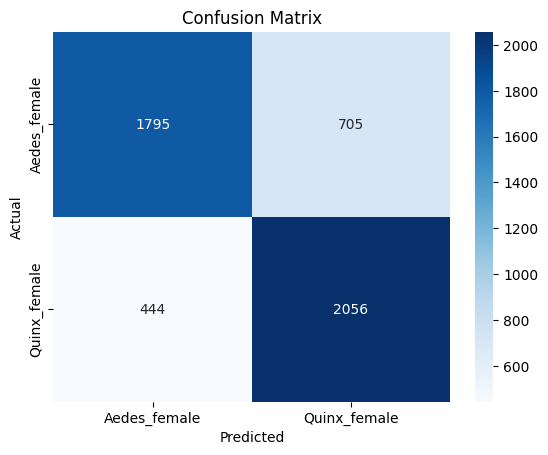

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_qva_test, y_qva_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Aedes_female', 'Quinx_female'], yticklabels=['Aedes_female', 'Quinx_female'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Classifier Gabungan

In [19]:
class SeranggaClassifier:
    def __init__(self, all_models):
        self.models = all_models

    def predict(self, X: pd.DataFrame):
        X = X.copy()

        # Level 1: RF untuk semua data
        rf_pred = self.models["rf"].predict(X)

        # Siapkan output akhir (urutannya sama!)
        final_pred = pd.Series(rf_pred, index=X.index, dtype=object)

        # ❗ KELAS YANG TIDAK DIPERCAYA RF
        need_refine = pd.Series(rf_pred).isin(
            ["Aedes_female", "Quinx_female"]
        ).values

        # Level 2: hanya untuk Aedes & Quinx
        if need_refine.any():
            final_pred[need_refine] = self.models["svc"].predict(
                X.loc[need_refine]
            )

        return final_pred.tolist()


In [20]:
classifiier = SeranggaClassifier({
    'rf' : random_forest,
    'svc': svc
})

y_pred_new = classifiier.predict(X_test)

In [23]:
joblib.dump(classifiier, 'serangga.pkl')

['serangga.pkl']

## EVALUASI

In [24]:
report = classification_report(y_test, y_pred_new)
print(report)

                 precision    recall  f1-score   support

   Aedes_female       0.73      0.65      0.69      2500
     Aedes_male       0.86      0.92      0.89      2500
    Fruit_flies       0.78      0.79      0.78      2500
    House_flies       0.76      0.79      0.78      2500
   Quinx_female       0.67      0.69      0.68      2500
     Quinx_male       0.63      0.62      0.63      2500
  Stigma_female       0.65      0.70      0.68      2500
    Stigma_male       0.80      0.86      0.83      2500
Tarsalis_female       0.87      0.78      0.82      2500
  Tarsalis_male       0.64      0.58      0.61      2500

       accuracy                           0.74     25000
      macro avg       0.74      0.74      0.74     25000
   weighted avg       0.74      0.74      0.74     25000



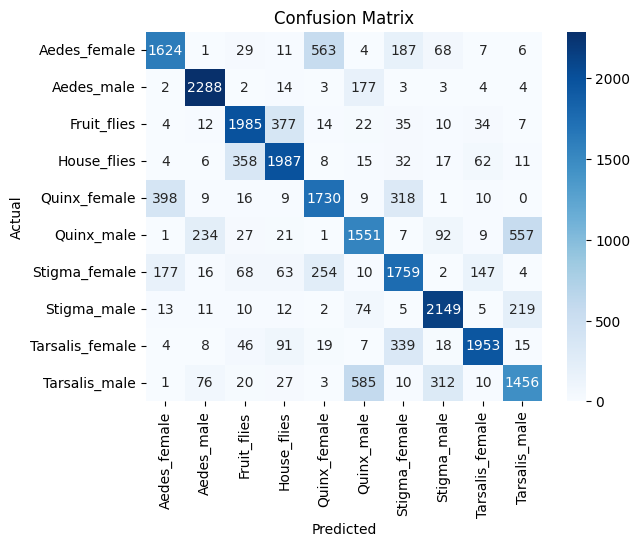

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_pred_new), annot=True, fmt='d', cmap='Blues', xticklabels=random_forest.classes_, yticklabels=random_forest.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

y_pred = pd.Series(y_pred_new, name="y_pred")
y_true = pd.Series(y_test, name="y_true")

female_classes = ["Aedes_female", "Quinx_female", 'Tarsalis_female']

# Mask HARUS dari ground truth
female_mask = y_true.isin(female_classes)

y_true_female = y_true[female_mask]
y_pred_female = y_pred[female_mask]

print("Jumlah data female:", len(y_true_female))
print(y_true_female.value_counts())

print("\n=== Classification Report (Female Only) ===")
print(
    classification_report(
        y_true_female,
        y_pred_female,
        labels=female_classes,
        zero_division=0
    )
)


Jumlah data female: 7500
y_true
Aedes_female       2500
Quinx_female       2500
Tarsalis_female    2500
Name: count, dtype: int64

=== Classification Report (Female Only) ===
                 precision    recall  f1-score   support

   Aedes_female       0.80      0.65      0.72      2500
   Quinx_female       0.75      0.69      0.72      2500
Tarsalis_female       0.99      0.78      0.87      2500

      micro avg       0.84      0.71      0.77      7500
      macro avg       0.85      0.71      0.77      7500
   weighted avg       0.85      0.71      0.77      7500



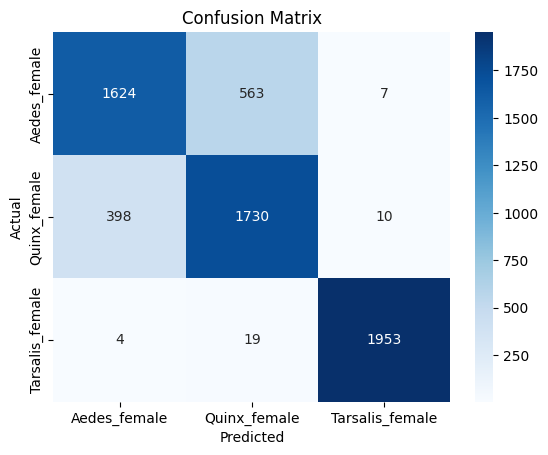

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_true_female, y_pred_female, labels=female_classes), annot=True, fmt='d', cmap='Blues', xticklabels=female_classes, yticklabels=female_classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()